In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
dropout_value = 0.05

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        # assume input shape 28x28x32 and we want output of 64 channels
        # so in_channels = 32 out_channels = 64
        super(DepthwiseSeparableConv, self).__init__()
        self.in_channels = in_channels
        self.depthwise = nn.Conv2d(
            1, 1, kernel_size, stride, padding, bias=False
        ) # 28x28x1 convolved with 3x3 to produce 28x28x1
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False) # 28x28x32 convolved with 1x1 to produce 28x28x64
        self.relu_and_norm_and_dropout = nn.Sequential(
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Dropout(dropout_value)
        )

    def forward(self, x):
        # assume input shape 28x28x32 and we want output of 64 channels
        outputs = []
        ch_num = 0
        for ch_num in range(self.in_channels):
            x1 = x[:,ch_num,:,:]
            ch_num = ch_num + 1
            x1 = x1.view(x1.shape[0],1,x1.shape[1],x1.shape[2])
            out_depthwise = self.depthwise(x1)
            outputs.append(out_depthwise)
        stacked_output = torch.stack(outputs, dim=-1) # 28x28x32
        stacked_output = stacked_output.view(stacked_output.shape[0],stacked_output.shape[4],stacked_output.shape[2],stacked_output.shape[3])
        out = self.pointwise(stacked_output) # 28x28x64
        out = self.relu_and_norm_and_dropout(out)
        return out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            # output_size = 32 , receptive_field = 3

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            # output_size = 32 , receptive_field = 5

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            # output_size = 16 , receptive_field = 7

            DepthwiseSeparableConv(in_channels=64, out_channels=128)
            # output_size = 16 , receptive_field = 11
        )

        # TRANSITION BLOCK 1
        self.transition1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16 , receptive_field = 11

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            # output_size = 16 , receptive_field = 15

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            # output_size = 16 , receptive_field = 21

            DepthwiseSeparableConv(in_channels=64, out_channels=128)
            # output_size = 16 , receptive_field = 25
        )

        # TRANSITION BLOCK 2
        self.transition2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16 , receptive_field = 25

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            # output_size = 16 , receptive_field = 29

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            # output_size = 16 , receptive_field = 33

            DepthwiseSeparableConv(in_channels=64, out_channels=128)
            # output_size = 16 , receptive_field = 37
        )
            
        # TRANSITION BLOCK 3
        self.transition3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16 , receptive_field = 37

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),
            # output_size = 16 , receptive_field = 41

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), dilation=2, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
            # output_size = 14 , receptive_field = 49

            DepthwiseSeparableConv(in_channels=64, out_channels=128)
            # output_size = 14 , receptive_field = 57
        )

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=14)
        ) # output_size = 1

        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.transition1(x)
        x = self.convblock2(x)
        x = self.transition2(x)
        x = self.convblock3(x)
        x = self.transition3(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)  # Flatten after GAP
        x = self.fc(x)

        return x

In [2]:
!pip install torchsummary

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 16, 16]          18,432
             ReLU-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
          Dropout-12           [-1, 64, 16, 16]               0
 

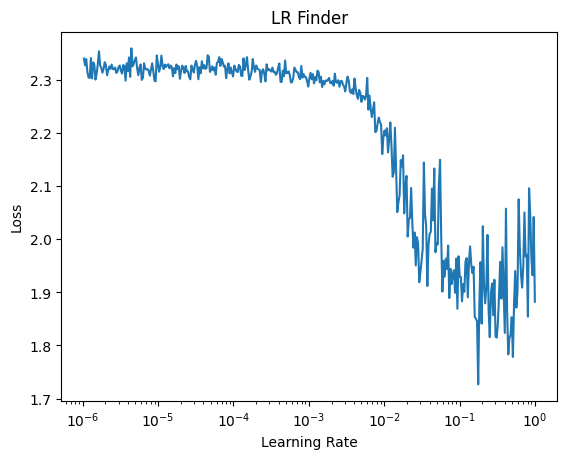

Optimal LR: 0.17704425612279368


In [44]:
from __future__ import print_function
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
#from model import Net  # Import the model from model.py

# CIFAR-10 Mean and Std (calculated over the entire dataset)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

# Albumentations Transformations
class AlbumentationsTransform:
    def __init__(self, mean, std):
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),  # Random horizontal flip
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),  # Shift, Scale, Rotate
            A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, 
                            fill_value=(np.array(mean) * 255).tolist(), mask_fill_value=None, p=0.5),  # CoarseDropout
            A.Normalize(mean=mean, std=std, max_pixel_value=255.0),  # Normalize
            ToTensorV2(),  # Convert to tensor
        ])
    
    def __call__(self, img):
        # Albumentations expects the image in OpenCV format (HWC, uint8)
        image = np.array(img)  # Convert PIL image to numpy array
        return self.transform(image=image)["image"]

# Apply Albumentations Transformations to CIFAR-10
train = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=AlbumentationsTransform(mean=CIFAR10_MEAN, std=CIFAR10_STD)
)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD)
])

test = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

criterion = nn.CrossEntropyLoss()
model =  Net().to(device)

def train(model, device, train_loader, optimizer,scheduler, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))


# LR Finder
def find_lr(model, train_loader, criterion, optimizer, device):
    model.train()
    lrs = []
    losses = []
    
    min_lr = 1e-6
    max_lr = 1
    num_steps = len(train_loader)
    print(f"Number of steps: {num_steps}")
    
    # Corrected lambda function for learning rate scaling
    lr_lambda = lambda x: min_lr * (max_lr / min_lr) ** (x / num_steps)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    for i, (inputs, labels) in enumerate(train_loader):
        if i >= num_steps:
            break

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        lrs.append(scheduler.get_last_lr()[0])
        losses.append(loss.item())

    # Plot the learning rate vs. loss
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('LR Finder')
    plt.show()

    return lrs, losses

optimizer = optim.SGD(model.parameters(), lr=1, momentum=0.9)
print("Finding optimal LR...")
lrs, losses = find_lr(model, train_loader, criterion, optimizer, device)
best_lr = lrs[losses.index(min(losses))]
print(f"Optimal LR: {best_lr}")

In [43]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 100
best_lr = 2e-2
optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=0.9)
scheduler = OneCycleLR(
    optimizer,
    max_lr=9e-2,  # max_lr provided to OneCycleLR
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    div_factor=((10*9.0)/(6.0)),   # Determines starting LR
    final_div_factor=1e4
)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer,scheduler, epoch)
    test(model, device, test_loader)
    print(f"Learning Rate = {optimizer.param_groups[0]['lr']}\n")
    if (test_acc[-1] > 88):
      break

EPOCH: 0


Loss=1.1646581888198853 Batch_id=390 Accuracy=49.57: 100%|██████████| 391/391 [01:02<00:00,  6.29it/s]



Test set: Average loss: 0.0094, Accuracy: 5539/10000 (55.39%)

Learning Rate = 0.006918112679208818

EPOCH: 1


Loss=1.4046542644500732 Batch_id=390 Accuracy=51.39: 100%|██████████| 391/391 [01:01<00:00,  6.32it/s]



Test set: Average loss: 0.0092, Accuracy: 5673/10000 (56.73%)

Learning Rate = 0.009632311150562692

EPOCH: 2


Loss=1.6144424676895142 Batch_id=390 Accuracy=52.26: 100%|██████████| 391/391 [01:02<00:00,  6.28it/s]



Test set: Average loss: 0.0091, Accuracy: 5721/10000 (57.21%)

Learning Rate = 0.014023931603088333

EPOCH: 3


Loss=1.3514219522476196 Batch_id=390 Accuracy=52.86: 100%|██████████| 391/391 [01:02<00:00,  6.26it/s]



Test set: Average loss: 0.0089, Accuracy: 5820/10000 (58.20%)

Learning Rate = 0.019900973921560178

EPOCH: 4


Loss=1.1151249408721924 Batch_id=390 Accuracy=53.63: 100%|██████████| 391/391 [01:02<00:00,  6.26it/s]



Test set: Average loss: 0.0088, Accuracy: 5890/10000 (58.90%)

Learning Rate = 0.027006495864605115

EPOCH: 5


Loss=1.4950546026229858 Batch_id=390 Accuracy=53.85: 100%|██████████| 391/391 [01:02<00:00,  6.24it/s]



Test set: Average loss: 0.0088, Accuracy: 5901/10000 (59.01%)

Learning Rate = 0.035029846489922856

EPOCH: 6


Loss=1.185120940208435 Batch_id=390 Accuracy=55.05: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s] 



Test set: Average loss: 0.0086, Accuracy: 6025/10000 (60.25%)

Learning Rate = 0.04362024770518757

EPOCH: 7


Loss=1.171527624130249 Batch_id=390 Accuracy=55.50: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s] 



Test set: Average loss: 0.0084, Accuracy: 6090/10000 (60.90%)

Learning Rate = 0.05240213016395996

EPOCH: 8


Loss=1.2249715328216553 Batch_id=390 Accuracy=56.01: 100%|██████████| 391/391 [01:02<00:00,  6.25it/s]



Test set: Average loss: 0.0084, Accuracy: 6122/10000 (61.22%)

Learning Rate = 0.06099155302658667

EPOCH: 9


Loss=1.2429659366607666 Batch_id=390 Accuracy=57.05: 100%|██████████| 391/391 [01:02<00:00,  6.26it/s]



Test set: Average loss: 0.0082, Accuracy: 6228/10000 (62.28%)

Learning Rate = 0.06901298971986466

EPOCH: 10


Loss=1.2219027280807495 Batch_id=390 Accuracy=57.98: 100%|██████████| 391/391 [01:02<00:00,  6.24it/s]



Test set: Average loss: 0.0080, Accuracy: 6335/10000 (63.35%)

Learning Rate = 0.07611574582790971

EPOCH: 11


Loss=1.4413691759109497 Batch_id=390 Accuracy=58.33: 100%|██████████| 391/391 [01:02<00:00,  6.26it/s]



Test set: Average loss: 0.0078, Accuracy: 6406/10000 (64.06%)

Learning Rate = 0.0819892913297635

EPOCH: 12


Loss=1.0656397342681885 Batch_id=390 Accuracy=59.39: 100%|██████████| 391/391 [01:02<00:00,  6.22it/s]



Test set: Average loss: 0.0076, Accuracy: 6508/10000 (65.08%)

Learning Rate = 0.08637683686365642

EPOCH: 13


Loss=1.2930467128753662 Batch_id=390 Accuracy=59.92: 100%|██████████| 391/391 [01:02<00:00,  6.26it/s]



Test set: Average loss: 0.0078, Accuracy: 6441/10000 (64.41%)

Learning Rate = 0.089086560468385

EPOCH: 14


Loss=1.2242950201034546 Batch_id=390 Accuracy=60.82: 100%|██████████| 391/391 [01:02<00:00,  6.23it/s]



Test set: Average loss: 0.0075, Accuracy: 6555/10000 (65.55%)

Learning Rate = 0.0899999988142592

EPOCH: 15


Loss=1.2708215713500977 Batch_id=390 Accuracy=61.03: 100%|██████████| 391/391 [01:02<00:00,  6.23it/s]



Test set: Average loss: 0.0076, Accuracy: 6566/10000 (65.66%)

Learning Rate = 0.08981791725184257

EPOCH: 16


Loss=1.0677824020385742 Batch_id=390 Accuracy=61.50: 100%|██████████| 391/391 [01:03<00:00,  6.20it/s]



Test set: Average loss: 0.0073, Accuracy: 6698/10000 (66.98%)

Learning Rate = 0.08927499058764629

EPOCH: 17


Loss=0.775687038898468 Batch_id=390 Accuracy=62.28: 100%|██████████| 391/391 [01:02<00:00,  6.22it/s] 



Test set: Average loss: 0.0072, Accuracy: 6718/10000 (67.18%)

Learning Rate = 0.08837559014793478

EPOCH: 18


Loss=0.8624030947685242 Batch_id=390 Accuracy=62.78: 100%|██████████| 391/391 [01:02<00:00,  6.22it/s]



Test set: Average loss: 0.0071, Accuracy: 6792/10000 (67.92%)

Learning Rate = 0.0871269573762097

EPOCH: 19


Loss=1.0328186750411987 Batch_id=390 Accuracy=63.03: 100%|██████████| 391/391 [01:02<00:00,  6.23it/s]



Test set: Average loss: 0.0069, Accuracy: 6862/10000 (68.62%)

Learning Rate = 0.08553914552936476

EPOCH: 20


Loss=0.8264871835708618 Batch_id=390 Accuracy=63.66: 100%|██████████| 391/391 [01:02<00:00,  6.23it/s]



Test set: Average loss: 0.0069, Accuracy: 6844/10000 (68.44%)

Learning Rate = 0.08362493873477256

EPOCH: 21


Loss=0.9775980114936829 Batch_id=390 Accuracy=63.99: 100%|██████████| 391/391 [01:02<00:00,  6.23it/s]



Test set: Average loss: 0.0069, Accuracy: 6902/10000 (69.02%)

Learning Rate = 0.08139974906000776

EPOCH: 22


Loss=0.948989748954773 Batch_id=390 Accuracy=64.54: 100%|██████████| 391/391 [01:03<00:00,  6.20it/s] 



Test set: Average loss: 0.0068, Accuracy: 6965/10000 (69.65%)

Learning Rate = 0.07888149242394123

EPOCH: 23


Loss=1.1936697959899902 Batch_id=390 Accuracy=64.57: 100%|██████████| 391/391 [01:02<00:00,  6.22it/s]



Test set: Average loss: 0.0066, Accuracy: 7007/10000 (70.07%)

Learning Rate = 0.07609044434829565

EPOCH: 24


Loss=1.0837770700454712 Batch_id=390 Accuracy=65.14: 100%|██████████| 391/391 [01:02<00:00,  6.22it/s]



Test set: Average loss: 0.0067, Accuracy: 7002/10000 (70.02%)

Learning Rate = 0.07304907671106643

EPOCH: 25


Loss=1.1403589248657227 Batch_id=390 Accuracy=65.46: 100%|██████████| 391/391 [01:02<00:00,  6.23it/s]



Test set: Average loss: 0.0065, Accuracy: 7092/10000 (70.92%)

Learning Rate = 0.06978187681617334

EPOCH: 26


Loss=0.8890126347541809 Batch_id=390 Accuracy=65.77: 100%|██████████| 391/391 [01:02<00:00,  6.23it/s]



Test set: Average loss: 0.0064, Accuracy: 7085/10000 (70.85%)

Learning Rate = 0.06631515023608762

EPOCH: 27


Loss=0.9742048382759094 Batch_id=390 Accuracy=66.14: 100%|██████████| 391/391 [01:02<00:00,  6.21it/s]



Test set: Average loss: 0.0063, Accuracy: 7160/10000 (71.60%)

Learning Rate = 0.0626768090148299

EPOCH: 28


Loss=1.0357816219329834 Batch_id=390 Accuracy=66.61: 100%|██████████| 391/391 [01:02<00:00,  6.22it/s]



Test set: Average loss: 0.0063, Accuracy: 7214/10000 (72.14%)

Learning Rate = 0.058896146936603756

EPOCH: 29


Loss=1.1402637958526611 Batch_id=390 Accuracy=67.00: 100%|██████████| 391/391 [01:02<00:00,  6.22it/s]



Test set: Average loss: 0.0064, Accuracy: 7181/10000 (71.81%)

Learning Rate = 0.05500360366946976

EPOCH: 30


Loss=1.1995701789855957 Batch_id=390 Accuracy=67.24: 100%|██████████| 391/391 [01:02<00:00,  6.21it/s]



Test set: Average loss: 0.0062, Accuracy: 7249/10000 (72.49%)

Learning Rate = 0.051030519683036506

EPOCH: 31


Loss=0.9513765573501587 Batch_id=390 Accuracy=67.40: 100%|██████████| 391/391 [01:02<00:00,  6.21it/s]



Test set: Average loss: 0.0061, Accuracy: 7322/10000 (73.22%)

Learning Rate = 0.04700888391342719

EPOCH: 32


Loss=0.9629236459732056 Batch_id=390 Accuracy=67.71: 100%|██████████| 391/391 [01:02<00:00,  6.22it/s]



Test set: Average loss: 0.0062, Accuracy: 7297/10000 (72.97%)

Learning Rate = 0.04297107620717517

EPOCH: 33


Loss=0.8625954389572144 Batch_id=390 Accuracy=68.12: 100%|██████████| 391/391 [01:02<00:00,  6.21it/s]



Test set: Average loss: 0.0061, Accuracy: 7323/10000 (73.23%)

Learning Rate = 0.03894960661773874

EPOCH: 34


Loss=0.9143396615982056 Batch_id=390 Accuracy=67.96: 100%|██████████| 391/391 [01:03<00:00,  6.20it/s]



Test set: Average loss: 0.0061, Accuracy: 7351/10000 (73.51%)

Learning Rate = 0.03497685365366615

EPOCH: 35


Loss=0.8280011415481567 Batch_id=390 Accuracy=68.28: 100%|██████████| 391/391 [01:02<00:00,  6.21it/s]



Test set: Average loss: 0.0060, Accuracy: 7325/10000 (73.25%)

Learning Rate = 0.03108480358588323

EPOCH: 36


Loss=0.8221684694290161 Batch_id=390 Accuracy=68.93: 100%|██████████| 391/391 [01:03<00:00,  6.17it/s]



Test set: Average loss: 0.0060, Accuracy: 7321/10000 (73.21%)

Learning Rate = 0.0273047929130474

EPOCH: 37


Loss=0.9643581509590149 Batch_id=390 Accuracy=68.75: 100%|██████████| 391/391 [01:03<00:00,  6.18it/s]



Test set: Average loss: 0.0059, Accuracy: 7327/10000 (73.27%)

Learning Rate = 0.023667256058486043

EPOCH: 38


Loss=1.0500160455703735 Batch_id=390 Accuracy=69.12: 100%|██████████| 391/391 [01:03<00:00,  6.16it/s]



Test set: Average loss: 0.0058, Accuracy: 7400/10000 (74.00%)

Learning Rate = 0.020201480330115047

EPOCH: 39


Loss=0.7748838663101196 Batch_id=390 Accuracy=69.49: 100%|██████████| 391/391 [01:03<00:00,  6.20it/s]



Test set: Average loss: 0.0059, Accuracy: 7377/10000 (73.77%)

Learning Rate = 0.016935370116256118

EPOCH: 40


Loss=0.8529924154281616 Batch_id=390 Accuracy=69.60: 100%|██████████| 391/391 [01:03<00:00,  6.17it/s]



Test set: Average loss: 0.0058, Accuracy: 7423/10000 (74.23%)

Learning Rate = 0.013895222215909568

EPOCH: 41


Loss=0.8084725141525269 Batch_id=390 Accuracy=69.95: 100%|██████████| 391/391 [01:03<00:00,  6.18it/s]



Test set: Average loss: 0.0057, Accuracy: 7445/10000 (74.45%)

Learning Rate = 0.011105514112390961

EPOCH: 42


Loss=0.9788846969604492 Batch_id=390 Accuracy=69.91: 100%|██████████| 391/391 [01:03<00:00,  6.17it/s]



Test set: Average loss: 0.0057, Accuracy: 7473/10000 (74.73%)

Learning Rate = 0.00858870689502802

EPOCH: 43


Loss=0.9608402252197266 Batch_id=390 Accuracy=70.25: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]



Test set: Average loss: 0.0057, Accuracy: 7505/10000 (75.05%)

Learning Rate = 0.006365064415676279

EPOCH: 44


Loss=0.8066905736923218 Batch_id=390 Accuracy=70.28: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]



Test set: Average loss: 0.0057, Accuracy: 7520/10000 (75.20%)

Learning Rate = 0.00445249013609888

EPOCH: 45


Loss=0.6811367273330688 Batch_id=390 Accuracy=70.41: 100%|██████████| 391/391 [01:03<00:00,  6.16it/s]



Test set: Average loss: 0.0057, Accuracy: 7486/10000 (74.86%)

Learning Rate = 0.002866382979819499

EPOCH: 46


Loss=0.9754640460014343 Batch_id=390 Accuracy=70.76: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]



Test set: Average loss: 0.0057, Accuracy: 7513/10000 (75.13%)

Learning Rate = 0.0016195133490445979

EPOCH: 47


Loss=0.8327924609184265 Batch_id=390 Accuracy=70.78: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]



Test set: Average loss: 0.0057, Accuracy: 7506/10000 (75.06%)

Learning Rate = 0.0007219203048937049

EPOCH: 48


Loss=0.7441520094871521 Batch_id=390 Accuracy=70.66: 100%|██████████| 391/391 [01:03<00:00,  6.15it/s]



Test set: Average loss: 0.0057, Accuracy: 7524/10000 (75.24%)

Learning Rate = 0.0001808307387821697

EPOCH: 49


Loss=0.9262151718139648 Batch_id=390 Accuracy=71.18: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]



Test set: Average loss: 0.0056, Accuracy: 7528/10000 (75.28%)

Learning Rate = 6.01185740799233e-07

